In [1]:
! ls ../input/severstalmodels
! ls ../input/pseudolabels-severstal

128x128.pth	       unet_mobilenet2.pth  unet_se_resnext50_32x4d.pth
resnet34_classify.pth  unet_resnet34.pth
mobilenet2_pseudo.pth  resnet34_pseudo.pth  se_resnext50_pseudo_170e.pth


### Install MLComp library(offline version):

As the competition does not allow commit with the kernel that uses internet connection, we use offline installation

In [2]:
! python ../input/mlcomp/mlcomp/mlcomp/setup.py

finished = 1 failed = 0
finished = 5 failed = 0
finished = 9 failed = 0
finished = 10 failed = 0
finished = 11 failed = 0
finished = 12 failed = 0
finished = 13 failed = 0
finished = 18 failed = 0
finished = 22 failed = 0
finished = 24 failed = 0
finished = 26 failed = 0
INSTALLATION SUCCESS


### Import required libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import matplotlib.pyplot as plt

import numpy as np
import cv2
import albumentations as A
from tqdm import tqdm_notebook
import pandas as pd

import torch
import torch.nn as nn
from torch.jit import load

from mlcomp.contrib.transform.albumentations import ChannelTranspose
from mlcomp.contrib.dataset.classify import ImageDataset
from mlcomp.contrib.transform.rle import rle2mask, mask2rle
from mlcomp.contrib.transform.tta import TtaWrap

In [4]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null
#package_path = '../input/unet-model'
package_path = '../input/unetmodelscript' # add unet script dataset
import sys
sys.path.append(package_path)

ERROR: mlcomp 19.9.3 requires psycopg2-binary>=2.8.2, which is not installed.
ERROR: mlcomp 19.9.3 requires pytest-xdist>=1.29.0, which is not installed.
ERROR: mlcomp 19.9.3 requires tiffile, which is not installed.
ERROR: mlcomp 19.9.3 has requirement scipy>=1.3.0, but you'll have scipy 1.2.1 which is incompatible.


In [5]:
# Get necessary Imports
import pdb
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Normalize, Compose)
from albumentations.pytorch import ToTensor
import torch.utils.data as data
import torchvision.models as models
import torch.nn as nn
from torch.nn import functional as F
from model import Unet

In [6]:
class ConvBn2d(nn.Module):

    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, stride=1):
        super(ConvBn2d, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn   = nn.BatchNorm2d(out_channel, eps=1e-5)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return x

# bottleneck type C
class BasicBlock(nn.Module):
    def __init__(self, in_channel, channel, out_channel, stride=1, is_shortcut=False):
        super(BasicBlock, self).__init__()
        self.is_shortcut = is_shortcut

        self.conv_bn1 = ConvBn2d(in_channel,    channel, kernel_size=3, padding=1, stride=stride)
        self.conv_bn2 = ConvBn2d(   channel,out_channel, kernel_size=3, padding=1, stride=1)

        if is_shortcut:
            self.shortcut = ConvBn2d(in_channel, out_channel, kernel_size=1, padding=0, stride=stride)


    def forward(self, x):
        z = F.relu(self.conv_bn1(x),inplace=True)
        z = self.conv_bn2(z)

        if self.is_shortcut:
            x = self.shortcut(x)

        z += x
        z = F.relu(z,inplace=True)
        return z
    

class ResNet34(nn.Module):

    def __init__(self, num_class=1000 ):
        super(ResNet34, self).__init__()


        self.block0  = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.block1  = nn.Sequential(
             nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
             BasicBlock( 64, 64, 64, stride=1, is_shortcut=False,),
          * [BasicBlock( 64, 64, 64, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.block2  = nn.Sequential(
             BasicBlock( 64,128,128, stride=2, is_shortcut=True, ),
          * [BasicBlock(128,128,128, stride=1, is_shortcut=False,) for i in range(1,4)],
        )
        self.block3  = nn.Sequential(
             BasicBlock(128,256,256, stride=2, is_shortcut=True, ),
          * [BasicBlock(256,256,256, stride=1, is_shortcut=False,) for i in range(1,6)],
        )
        self.block4 = nn.Sequential(
             BasicBlock(256,512,512, stride=2, is_shortcut=True, ),
          * [BasicBlock(512,512,512, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.logit = nn.Linear(512,num_class)

    def forward(self, x):
        batch_size = len(x)

        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        logit = self.logit(x)
        return logit

In [7]:
class ConvBn2dGroups(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, dilation=1, stride=1, groups=1, is_bn=True):
        super(ConvBn2dGroups, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, 
                              stride=stride, dilation=dilation, groups=groups, bias=False)
        self.bn   = nn.BatchNorm2d(out_channels, eps=1e-5)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return x

In [8]:
class SENextBottleneckBlock(nn.Module):
    def __init__(self, in_channel, channel, out_channel, stride=1, group=32, reduction=16, excite_size=-1, is_shortcut=False):
        super(SENextBottleneckBlock, self).__init__()
        self.is_shortcut = is_shortcut

        self.conv_bn1 = ConvBn2dGroups(in_channel,     channel, kernel_size=1, padding=0, stride=1)
        self.conv_bn2 = ConvBn2dGroups(   channel,     channel, kernel_size=3, padding=1, stride=stride, groups=group)
        self.conv_bn3 = ConvBn2dGroups(   channel, out_channel, kernel_size=1, padding=0, stride=1)
        self.scale    = SqueezeExcite(out_channel, reduction, excite_size)

        if is_shortcut:
            self.shortcut = ConvBn2dGroups(in_channel, out_channel, kernel_size=1, padding=0, stride=stride)


    def forward(self, x):
        z = F.relu(self.conv_bn1(x),inplace=True)
        z = F.relu(self.conv_bn2(z),inplace=True)
        z = self.scale(self.conv_bn3(z))

        if self.is_shortcut:
            z += self.shortcut(x)
        else:
            z += x

        z = F.relu(z,inplace=True)
        return z

    
class SqueezeExcite(nn.Module):
    def __init__(self, in_channel, reduction=4, excite_size=-1):
        super(SqueezeExcite, self).__init__()
        self.excite_size=excite_size
        self.fc1 = nn.Conv2d(in_channel, in_channel//reduction, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(in_channel//reduction, in_channel, kernel_size=1, padding=0)
        self.gather_excite = False

    def forward(self, x):

        if self.gather_excite:
            s = F.avg_pool2d(x, kernel_size=self.excite_size)
        else:
            s = F.adaptive_avg_pool2d(x,1)

        s = self.fc1(s)
        s = F.relu(s, inplace=True)
        s = self.fc2(s)

        if self.gather_excite:
            s = F.interpolate(s, size=(x.shape[2],x.shape[3]), mode='nearest')

        x = x*torch.sigmoid(s)
        return x
    
    
#resnext50_32x4d
class ResNext50(nn.Module):
    def __init__(self, num_class=1000 ):
        super(ResNext50, self).__init__()

        self.block0  = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.block1  = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=0, stride=2, ceil_mode=True),
             SENextBottleneckBlock( 64, 128, 256, stride=1, is_shortcut=True,  excite_size=64),
          * [SENextBottleneckBlock(256, 128, 256, stride=1, is_shortcut=False, excite_size=64) for i in range(1,3)],
        )

        self.block2  = nn.Sequential(
             SENextBottleneckBlock(256, 256, 512, stride=2, is_shortcut=True,  excite_size=32),
          * [SENextBottleneckBlock(512, 256, 512, stride=1, is_shortcut=False, excite_size=32) for i in range(1,4)],
        )

        self.block3  = nn.Sequential(
             SENextBottleneckBlock( 512,512,1024, stride=2, is_shortcut=True,  excite_size=16),
          * [SENextBottleneckBlock(1024,512,1024, stride=1, is_shortcut=False, excite_size=16) for i in range(1,6)],
        )

        self.block4 = nn.Sequential(
             SENextBottleneckBlock(1024,1024,2048, stride=2, is_shortcut=True,  excite_size=8),
          * [SENextBottleneckBlock(2048,1024,2048, stride=1, is_shortcut=False, excite_size=8) for i in range(1,3)],
        )

        self.logit = nn.Linear(2048,num_class)


    def forward(self, x):
        batch_size = len(x)

        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        logit = self.logit(x)
        return logit

In [9]:
class Resnext50_classification(nn.Module):
    def load_pretrain(self, skip=['logit.'], is_print=True):
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=is_print)


    def __init__(self, num_class=4):
        super(Resnext50_classification, self).__init__()

        e = ResNext50()
        self.block0 = e.block0
        self.block1 = e.block1
        self.block2 = e.block2
        self.block3 = e.block3
        self.block4 = e.block4
        e = None  #dropped

        self.feature = nn.Conv2d(2048, 64, kernel_size=1) #dummy conv for dim reduction
        self.logit   = nn.Conv2d(64, num_class, kernel_size=1)



    def forward(self, x):
        batch_size,C,H,W = x.shape
        x = x.clone()
        x = x-torch.FloatTensor(mean).to(x.device).view(1,-1,1,1)
        x = x/torch.FloatTensor(std).to(x.device).view(1,-1,1,1)

        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = F.dropout(x, 0.5, training=self.training)
        x = F.avg_pool2d(x, kernel_size=(8, 13),stride=(8, 8))
        #x = F.adaptive_avg_pool2d(x, 1)
        x = self.feature(x)

        logit = self.logit(x) #.view(batch_size,-1)
        return logit
    
    
class Resnet34_classification(nn.Module):
    def __init__(self,num_class=4):
        super(Resnet34_classification, self).__init__()
        e = ResNet34()
        self.block = nn.ModuleList([
            e.block0,
            e.block1,
            e.block2,
            e.block3,
            e.block4,
        ])
        e = None  #dropped
        self.feature = nn.Conv2d(512,32, kernel_size=1) #dummy conv for dim reduction
        self.logit = nn.Conv2d(32,num_class, kernel_size=1)

    def forward(self, x):
        batch_size,C,H,W = x.shape

        for i in range( len(self.block)):
            x = self.block[i](x)
            #print(i, x.shape)

        x = F.dropout(x,0.5,training=self.training)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.feature(x)
        logit = self.logit(x)
        return logit

In [10]:
model_resnext50_1 = Resnext50_classification()
model_resnext50_2 = Resnext50_classification()
#model_resnext50_3 = Resnext50_classification()
#model_resnext50_4 = Resnext50_classification()
#model_resnext50_5 = Resnext50_classification()

# around 0.91198
#model_resnext50.load_state_dict(torch.load('../input/steel-detection-classifier/00049999_model.pth', map_location=lambda storage, loc: storage), strict=True) 

# 0.91311 when combined
model_resnext50_1.load_state_dict(torch.load('../input/steel-detection-classifier/00053000_model.pth', map_location=lambda storage, loc: storage), strict=True) 

# 0.91262 when combined
#model_resnext50.load_state_dict(torch.load('../input/steel-detection-classifier/00058000_model.pth', map_location=lambda storage, loc: storage), strict=True) 

#model_resnext50_2.load_state_dict(torch.load('../input/steel-detection-classifier/00084000_model.pth', map_location=lambda storage, loc: storage), strict=True)

#model_resnext50_1.load_state_dict(torch.load('../input/steel-detection-classifier/00088000_model.pth', map_location=lambda storage, loc: storage), strict=True)

#model_resnext50_2.load_state_dict(torch.load('../input/steel-detection-classifier/00090000_model.pth', map_location=lambda storage, loc: storage), strict=True)

#model_resnext50_5.load_state_dict(torch.load('../input/steel-detection-classifier/00092000_model.pth', map_location=lambda storage, loc: storage), strict=True)

#model_resnext50_3.load_state_dict(torch.load('../input/steel-detection-classifier/00093000_model.pth', map_location=lambda storage, loc: storage), strict=True)

model_resnext50_2.load_state_dict(torch.load('../input/steel-detection-classifier/00094000_model.pth', map_location=lambda storage, loc: storage), strict=True)

#model_resnext50_2.load_state_dict(torch.load('../input/steel-detection-classifier/00095000_model.pth', map_location=lambda storage, loc: storage), strict=True)

#model_resnext50_5.load_state_dict(torch.load('../input/steel-detection-classifier/00097000_model.pth', map_location=lambda storage, loc: storage), strict=True)

#model_resnext50_10.load_state_dict(torch.load('../input/steel-detection-classifier/00098000_model.pth', map_location=lambda storage, loc: storage), strict=True)

# resnet34 

model_resnet34 = Resnet34_classification()
model_resnet34.load_state_dict(torch.load('../input/clsification/00007500_model.pth', map_location=lambda storage, loc: storage), strict=True)

<All keys matched successfully>

In [11]:
# Dataset setup
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [12]:
sample_submission_path = '../input/severstal-steel-defect-detection/sample_submission.csv'
test_data_folder = "../input/severstal-steel-defect-detection/test_images"

In [13]:
# hyperparameters
batch_size = 1

# mean and std
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [14]:
df = pd.read_csv(sample_submission_path)

In [15]:
# dataloader
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [16]:
def sharpen(p,t=0.5):
        if t!=0:
            return p**t
        else:
            return p

def get_classification_preds(net, test_loader):
    test_probability_label = []
    test_id   = []
    
    net = net.cuda()
    for t, (fnames, images) in enumerate(tqdm(test_loader)):
        batch_size,C,H,W = images.shape
        images = images.cuda()

        with torch.no_grad():
            net.eval()

            num_augment = 0
            logit =  net(images) 
            logit = logit.max(-1,True)[0]
            probability = torch.sigmoid(logit)

            probability_label = sharpen(probability,0)
            num_augment+=1

            if 'flip_lr' in augment:
                logit = net(torch.flip(images,dims=[3]))
                probability  = torch.sigmoid(logit)

                probability_label += sharpen(probability)
                num_augment+=1

            if 'flip_ud' in augment:
                logit = net(torch.flip(images,dims=[2]))
                probability = torch.sigmoid(logit)

                probability_label += sharpen(probability)
                num_augment+=1

            probability_label = probability_label/num_augment

        probability_label = probability_label.data.cpu().numpy()
        
        test_probability_label.append(probability_label)
        test_id.extend([i for i in fnames])

    test_probability_label = np.concatenate(test_probability_label)
    return test_probability_label, test_id

augment = ['null'] #['null', 'flip_lr','flip_ud'] #['null', 'flip_lr','flip_ud'] #['null, 'flip_lr','flip_ud','5crop']

# Get prediction for classification mode
probability_label_resnet34, image_id = get_classification_preds(model_resnet34, testset)
print(probability_label_resnet34.mean())

probability_label_resnext50_1, image_id = get_classification_preds(model_resnext50_1, testset)
print(probability_label_resnext50_1.mean())

probability_label_resnext50_2, image_id = get_classification_preds(model_resnext50_2, testset)
print(probability_label_resnext50_2.mean())

#probability_label_resnext50_3, image_id = get_classification_preds(model_resnext50_3, testset)
#print(probability_label_resnext50_3.mean())
#
#probability_label_resnext50_4, image_id = get_classification_preds(model_resnext50_4, testset)
#print(probability_label_resnext50_4.mean())
#
#probability_label_resnext50_5, image_id = get_classification_preds(model_resnext50_5, testset)
#print(probability_label_resnext50_5.mean())

  0%|          | 2/1801 [00:00<01:43, 17.38it/s]

0.13750789


  0%|          | 2/1801 [00:00<01:39, 18.14it/s]

0.17952399


100%|██████████| 1801/1801 [01:39<00:00, 18.18it/s]

0.15742898


In [17]:
#probability_label_resnext50 = np.mean([probability_label_resnext50_1, probability_label_resnext50_2, probability_label_resnext50_3, 
#                                       probability_label_resnext50_4, probability_label_resnext50_5], axis=0)

probability_label = np.mean([probability_label_resnet34, probability_label_resnext50_1, probability_label_resnext50_2], axis=0)

print(probability_label.mean())

0.15815362


In [18]:
## threshold for classification

#threshold_label = [0.5,0.5,0.5,0.5] # lb: best so far 0.91311
#threshold_label = [0.4,0.4,0.4,0.4] # lb: 0.91288

#threshold_label = [0.45,0.5,0.30,0.35] # lb: 0.91235
#threshold_label = [0.95,0.9,0.80,0.85] # this does not make sense but is here for reference

#threshold_label  = [0.60,0.65,0.45,0.50] 
#threshold_label  = [0.65,0.75,0.45,0.55] # lb: best so far 0.91328
threshold_label  = [0.55,0.65,0.42,0.50] # lb: best so far 0.91328

predict_label = probability_label>np.array(threshold_label).reshape(1,4,1,1)

In [19]:
image_id_class_id = []
encoded_pixel = []
confidence = []

for b in range(len(image_id)):
    for c in range(4):
        image_id_class_id.append(image_id[b]+'_%d'%(c+1))
        if predict_label[b,c]==0:
            rle=''
        else:
            rle ='1 1'
        encoded_pixel.append(rle)
        confidence.append(probability_label[b,c][0][0])

df_classification = pd.DataFrame(zip(image_id_class_id, encoded_pixel), columns=['ImageId_ClassId', 'EncodedPixels'])

confidence_df = pd.DataFrame(zip(image_id, confidence), columns=['ImageId_ClassId', 'Confidence'])

In [20]:
confidence_df.head()

,ImageId_ClassId,Confidence
0,004f40c73.jpg,0.019161
1,006f39c41.jpg,0.037442
2,00b7fb703.jpg,0.336553
3,00bbcd9af.jpg,0.017361
4,0108ce457.jpg,0.548352


In [21]:
#confidence_df.to_csv('classifier_test_confidence.csv', index=False)
confidence_df.to_pickle('classifier_test_confidence.pickle')

In [22]:
df_classification.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


In [23]:
len(df_classification[df_classification.EncodedPixels == '']), len(df_classification[df_classification.EncodedPixels != ''])
#(6267, 937) for hengs resnet34

(6187, 1017)

## Segmentation

### Load models

Catalyst allows to trace models. That is an extremely useful features in Pytorch since 1.0 version: 

https://pytorch.org/docs/stable/jit.html

Now we can load models without re-defining them

In [24]:
unet_se_resnext50_32x4d = load('/kaggle/input/severstalmodels/unet_se_resnext50_32x4d.pth').cuda()
unet_mobilenet2 = load('/kaggle/input/severstalmodels/unet_mobilenet2.pth').cuda()
unet_resnet34 = load('/kaggle/input/severstalmodels/unet_resnet34.pth').cuda()

#increases public leaderboard when added, decreases when standalone seresnext
#unet_se_resnext50_pseudo = load('/kaggle/input/pseudolabels-severstal/se_resnext50_pseudo_170e.pth').cuda() 

#increases public leaderboard when it's added standalone resnet34 increases score only slightly!
unet_resnet34_pseudo = load('/kaggle/input/pseudolabels-severstal/resnet34_pseudo.pth').cuda()  

#decreases public lb when added, decreases when standalone mobilenet2
unet_mobilenet2_pseudo = load('/kaggle/input/pseudolabels-severstal/mobilenet2_pseudo.pth').cuda() 

### Models' mean aggregator

In [25]:
class Model:
    def __init__(self, models):
        self.models = models
    
    def __call__(self, x):
        res = []
        x = x.cuda()
        with torch.no_grad():
            for m in self.models:
                res.append(m(x))
        res = torch.stack(res)
        return torch.mean(res, dim=0)

model = Model([unet_resnet34, unet_resnet34_pseudo, unet_mobilenet2, unet_se_resnext50_32x4d]) #unet_mobilenet2_pseudo

### Create TTA transforms, datasets, loaders

In [26]:
def create_transforms(additional):
    res = list(additional)
    # add necessary transformations
    res.extend([
        A.Normalize(
            #mean=(0.485, 0.456, 0.406), std=(0.230, 0.225, 0.223)
            mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
        ),
        ChannelTranspose()
    ])
    res = A.Compose(res)
    return res

img_folder = '/kaggle/input/severstal-steel-defect-detection/test_images'
batch_size = 2
num_workers = 0

# Different transforms for TTA wrapper
transforms = [
    [],
    [A.HorizontalFlip(p=1)]
]
#transforms = [
#    [A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.230, 0.225, 0.223)), ChannelTranspose()],
#    [A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.230, 0.225, 0.223)), ChannelTranspose(), A.HorizontalFlip(p=1)],
#    [A.Normalize(mean=(0.456, 0.485, 0.406), std=(0.225, 0.230, 0.223)), ChannelTranspose()],
#    [A.Normalize(mean=(0.456, 0.485, 0.406), std=(0.225, 0.230, 0.223)), ChannelTranspose(), A.HorizontalFlip(p=1)]
#]
#transforms = [
#    [],
#    [A.HorizontalFlip(p=1)]
#    [A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=.75)],
#    [A.GaussNoise(var_limit=(10, 20))],
#]

transforms = [create_transforms(t) for t in transforms]
datasets = [TtaWrap(ImageDataset(img_folder=img_folder, transforms=t), tfms=t) for t in transforms]
loaders = [DataLoader(d, num_workers=num_workers, batch_size=batch_size, shuffle=False) for d in datasets]

### Loaders' mean aggregator

In [27]:
thresholds = [0.5, 0.5,  0.5,  0.5]
min_area   = [600, 600, 1000, 2000]

#thresholds           = [ 0.50, 0.50, 0.50, 0.50,]
#threshold_label      = [ 0.75, 0.99, 0.50, 0.50,]
#min_area             = [    1,    1,    1,    1,]

res = []
# Iterate over all TTA loaders
total = len(datasets[0])//batch_size
for loaders_batch in tqdm_notebook(zip(*loaders), total=total):
    preds = []
    image_file = []
    for i, batch in enumerate(loaders_batch):
        features = batch['features'].cuda()
        p = torch.sigmoid(model(features))
        # inverse operations for TTA
        p = datasets[i].inverse(p)
        preds.append(p)
        image_file = batch['image_file']
    
    # TTA mean
    preds = torch.stack(preds)
    preds = torch.mean(preds, dim=0)
    preds = preds.detach().cpu().numpy()
    
    # Batch post processing
    for p, file in zip(preds, image_file):
        file = os.path.basename(file)
        # Image postprocessing
        for i in range(4):
            p_channel = p[i]
            imageid_classid = file+'_'+str(i+1)
            
            max_confidence = p_channel.max()
            mean_confidence = p_channel.mean()
            median_confidence = np.median(p_channel)
            std_confidence = p_channel.std()
            
            #label_threshold = max_confidence > threshold_label[i]
            
            #mask = ((p_channel > thresholds[i]) * label_threshold).astype(np.uint8)
            mask = (p_channel > thresholds[i]).astype(np.uint8)
            if mask.sum() < min_area[i]:
                mask = np.zeros(mask.shape, dtype=mask.dtype)

            res.append({
                'ImageId_ClassId': imageid_classid,
                'EncodedPixels': mask2rle(mask),
                'MaxConfidence': max_confidence,
                'MeanConfidence': mean_confidence,
                'MedianConfidence': median_confidence,
                'StdConfidence': std_confidence,
                #'Confidence': p_channel.astype(np.float16)
            })

In [28]:
df = pd.DataFrame(res)
df = df.fillna('')

df.head()

,ImageId_ClassId,EncodedPixels,MaxConfidence,MeanConfidence,MedianConfidence,StdConfidence
0,004f40c73.jpg_1,,0.000253,1.482411e-06,1.203348e-07,0.000007
1,004f40c73.jpg_2,,0.000117,3.960590e-07,1.565011e-08,0.000003
2,004f40c73.jpg_3,,0.007642,2.358327e-05,1.072028e-07,0.000271
3,004f40c73.jpg_4,,0.000045,5.532236e-07,8.746819e-09,0.000002
4,006f39c41.jpg_1,,0.015568,1.283368e-05,1.247685e-06,0.000205


### ensambling masks (union)

In [29]:
#df_fastai = pd.read_csv('../input/fastai-submission-256crops/submission.csv').fillna('')

In [30]:
#df_fastai.head()

In [31]:
#len(df_fastai[df_fastai.EncodedPixels!='']), len(df[df.EncodedPixels!=''])

In [32]:
#rle_list1 = list(df.EncodedPixels)
#rle_list2 = list(df_fastai.EncodedPixels)

#rle_output = []
#for i in range(len(rle_list1)):
#    mask1 = rle2mask(rle_list1[i], (256,1600))
#    mask2 = rle2mask(rle_list2[i], (256,1600))
#    rle_output.append(mask2rle(np.ceil((mask1+mask2)/2)))    

In [33]:
#df.EncodedPixels = rle_output

### use classification to reduce false positives

In [34]:
df_classification.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


In [35]:
assert(np.all(df['ImageId_ClassId'].values == df_classification['ImageId_ClassId'].values))
print((df.loc[df_classification['EncodedPixels']=='','EncodedPixels'] != '').sum() ) #172
df.loc[df_classification['EncodedPixels']=='','EncodedPixels']=''

79


Save predictions

In [36]:
df[['ImageId_ClassId', 'EncodedPixels']].to_csv("submission.csv", index=False)

In [37]:
#df.to_csv("segmentation_test_confidence.csv", index=False)
df.to_pickle('segmentation_test_confidence.pickle')

Histogram of predictions

In [38]:
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['Class'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[1])
df['empty'] = df['EncodedPixels'].map(lambda x: not x)
df[df['empty'] == False]['Class'].value_counts()

3    598
4    109
1     55
Name: Class, dtype: int64

### Visualization

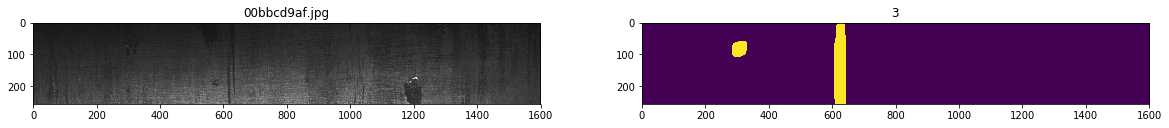

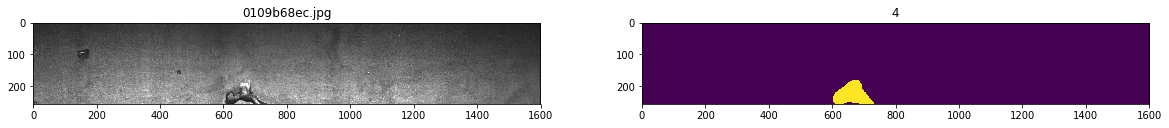

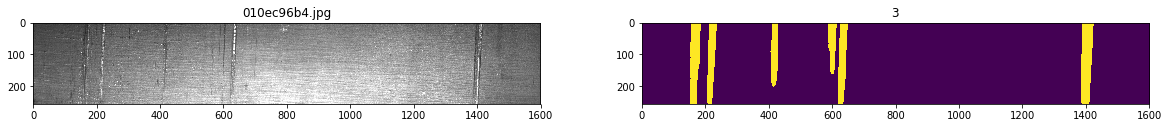

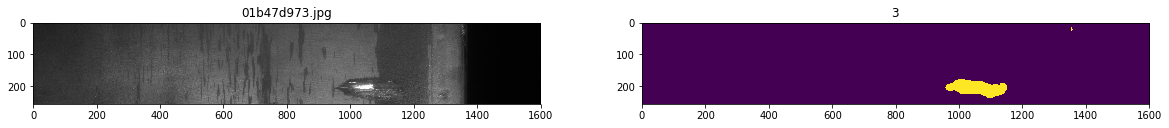

In [39]:
%matplotlib inline

df = pd.read_csv('submission.csv')[:40]
df['Image'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[0])
df['Class'] = df['ImageId_ClassId'].map(lambda x: x.split('_')[1])

for row in df.itertuples():
    img_path = os.path.join(img_folder, row.Image)
    img = cv2.imread(img_path)
    mask = rle2mask(row.EncodedPixels, (1600, 256)) \
        if isinstance(row.EncodedPixels, str) else np.zeros((256, 1600))
    if mask.sum() == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 60))
    axes[0].imshow(img/255)
    axes[1].imshow(mask*60)
    axes[0].set_title(row.Image)
    axes[1].set_title(row.Class)
    plt.show()